In [105]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader as DL

import numpy as np
import pandas as pd
from tqdm import tqdm

import typing

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [68]:
# torch.manual_seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [69]:
# Normalizing mnist data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307), (0.3081,))])
# transform=transforms.ToTensor()
invTrans = transforms.Compose([ transforms.Normalize((0.),( 1/0.3081 )),transforms.Normalize((-0.1307),(1.)),])

In [70]:
training_data = MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

testing_data = MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

In [71]:
print(len(training_data))
print(len(testing_data))

60000
10000


In [72]:
train_ds = DL(training_data ,batch_size=32,shuffle=True)
test_ds = DL(testing_data ,batch_size = 32)

In [73]:
# Autoencoder and Variable Auto Encoder classes
class Autoencoder(torch.nn.Module):
    def __init__(self,input_size,hidden,bottleneck):
        super().__init__()
        
        self.fc1 = nn.Linear(input_size,hidden)
        self.al1=nn.Tanh()
        self.fc2 = nn.Linear(hidden, bottleneck) #Obtained Encoding

        self.fc3 = nn.Linear(bottleneck, hidden)# Decoder starts here
        self.al2 = nn.Tanh()
        self.fc4 = nn.Linear(hidden, input_size)

    def encoder(self, x):
        m = torch.flatten(x, 1)
        m = self.fc1(m)
        m= self.al1(m)
        return self.fc2(m) 
    
    def decoder(self, x):
        m = self.fc3(x)
        m= self.al2(m)
        return self.fc4(m) 
    
    def forward(self,x):
        return self.decoder(self.encoder(x))


class VAE(torch.nn.Module):
    def __init__(self,input_size,hidden,bottleneck):
        super().__init__()
        
        self.fc1 = nn.Linear(input_size,hidden)
        self.al1=nn.Tanh()
        self.fc21 = nn.Linear(hidden, bottleneck) #mean of distribution
        self.fc22 = nn.Linear(hidden, bottleneck) #var of distribution

        self.fc3 = nn.Linear(bottleneck, hidden)# Decoder starts here
        self.al2 = nn.Tanh()
        self.fc4 = nn.Linear(hidden, input_size)
        
    def encoder(self, x):
        m = torch.flatten(x, 1)
        m = self.fc1(m)
        m= self.al1(m)
        return self.fc21(m), self.fc22(m) 
    
    # Models distibution not point unlike AE
    def sampling(self, mu, std):
        eps = torch.randn_like(mu) #Normal distribution results
        return eps*std + mu         #Reparametrization

    # Using z in order to show we are using p(z|x)
    def decoder(self, z):
        m = self.fc3(z)
        m= self.al2(m)
        return self.fc4(m) 
    
    def forward(self, x):
        mu, std = self.encoder(x)
        z = self.sampling(mu, std)
        return self.decoder(z)
    



In [74]:
# Initialize the models
vae = VAE(784,100,10)
ae=Autoencoder(784,100,10)
vae.to(device)
ae.to(device)
opt_vae =  torch.optim.Adam(vae.parameters(), lr  = 0.001)
opt_ae =  torch.optim.Adam(ae.parameters(), lr  = 0.001)

In [75]:
# Loss calculation function
def calc_loss(dl,model,loss_fn):
    model.eval()
    loss = 0
    count = 0
    for index,(image, target) in enumerate(dl):
        image = image.to(device)
        flat_img = torch.flatten(image, 1)
        loss = loss + loss_fn(model(image), flat_img).item()
        count = count + 1
    return loss/count

In [76]:
# Training loop
def train_and_plot(model:VAE|Autoencoder,opt:torch.optim.Optimizer,train_ds:DL,test_ds:DL,loss_fn = torch.nn.MSELoss()):
    train_losses = []
    test_losses = []
    for epoch in tqdm(range(3)):
        for index,(image, target) in (enumerate(tqdm(train_ds, leave=True))):
            model.train()
            opt.zero_grad()
            image = image.to(device)
            flat_img = torch.flatten(image, 1)
            op = model(image)
            loss = loss_fn(op, flat_img)
            loss.backward()
            opt.step()
            if(index %300 == 0):
                train_losses.append(loss.item())
                test_loss = calc_loss(test_ds, model,loss_fn)
                test_losses.append(test_loss)
    plt.plot(train_losses, label='train_losses')
    plt.plot(test_losses, label= 'test_losses')
    plt.xlabel('Index per 300 iterations')
    plt.legend()
    plt.show()
    return train_losses,test_losses

100%|██████████| 3/3 [01:05<00:00, 21.76s/it]


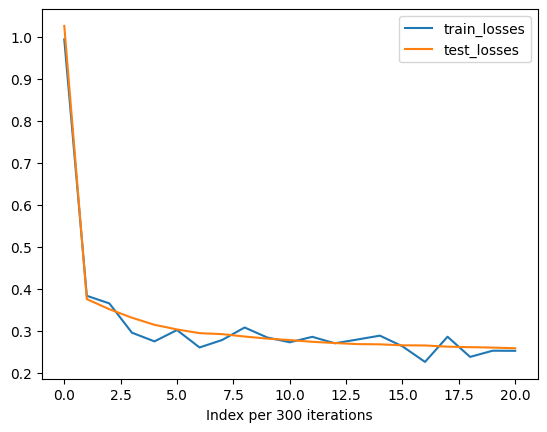

100%|██████████| 3/3 [01:00<00:00, 20.18s/it]


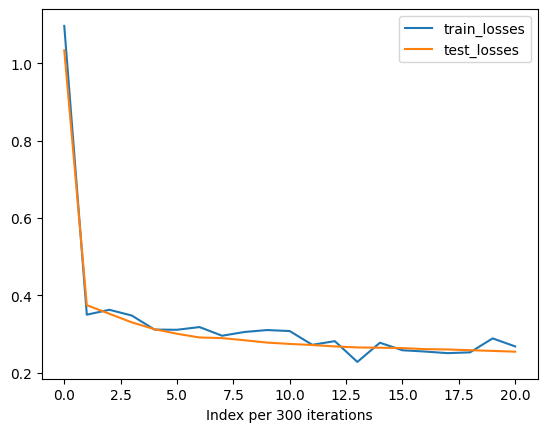

In [77]:
vae_losses=train_and_plot(vae,opt_vae,train_ds,test_ds)
ae_losses=train_and_plot(ae,opt_ae,train_ds,test_ds)

In [121]:
# Get latent embedding
def get_latent(img:torch.Tensor,model:VAE|Autoencoder):
    model.eval()
    img=img.to(device)
    res=model.encoder(img)
    # Return sampled point in latent space from the predicted distribution mode gives for an image
    # KARTIK should we just pass variance as 0 ,since this is a learned model and we are trying to draw lines bw 2 points
    # and not generate new data
    if(isinstance(model,VAE)):
        res=model.sampling(*res)

    # for simple Encoder just returns the latent space representation of the point
    return res.detach().cpu().numpy()

# Pefrom PCA and do pair plots for certain "interesting" sets of digits
def PCA_and_plot_latent(data_loader,model,comp_cnt=3):
    latent_reps=[]
    latent_tars=[]
    # Get points in latent space for all the digits 
    for index,(image, target) in enumerate(data_loader):
        
        latent_space=get_latent(image,model)
        latent_tars.extend(target)
        for i in range(latent_space.shape[0]):
            latent_reps.append(latent_space[i, :])
    latent_tars=np.array([int(x) for x in latent_tars])

    # Scaling data before PCA
    scaling=StandardScaler()
    scaling.fit(latent_reps)
    scaled_latent_reps=scaling.transform(latent_reps)
    
    # Create uniform palette for each digit
    labels= [x for x in range(10)]
    custom_palette = {label: sns.color_palette('tab10')[i] for i, label in enumerate(set(labels))}

    # perform PCA
    pca=PCA(n_components=comp_cnt)
    pca.fit(scaled_latent_reps)
    x=pca.transform(scaled_latent_reps)
    tot_exp_var=sum(pca.explained_variance_ratio_)

    # Create df out of PCA results
    df = pd.DataFrame({f'PC{i+1}': x[:,i] for i in range(comp_cnt)})
    df["labels"]=latent_tars

    # Overall plotting
    print(f"Overall PCA results ,{100*tot_exp_var:.2f} % variance is explained")
    sns.pairplot(df, hue="labels",palette=custom_palette)
    
    plt.show()

    # Cases of interest are plotted
    for i,vals in enumerate([[2,7],[0,1],[3,5],[4,6]]):
        print("Showing pairplots of PCA for digits ",end="")
        for dig in vals:
            print(dig,end=" ,")
        indices=np.where(np.isin(latent_tars, vals))
        filtered_df = df[df['labels'].isin(vals)]
        sns.pairplot(filtered_df,hue='labels',palette=custom_palette)
        plt.show()


    # fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # for i,vals in enumerate([[2,5,7],[0,1],[3,5],[1,7,9]]):
    #     indices=np.where(np.isin(latent_tars, vals))
    #     # print(latent_tars[indices])
    #     # print(indices)
    #     filtered_x = x[indices]

    #     filtered_latent_tars = latent_tars[indices]

    #     sns.scatterplot(x=filtered_x[:,0],y=filtered_x[:,1],hue=filtered_latent_tars,palette=custom_palette,ax=axes[int(i>=2), i%2])
    # plt.tight_layout()

    # # Show the plot
    # plt.show()



Overall PCA results ,54.14 % variance is explained


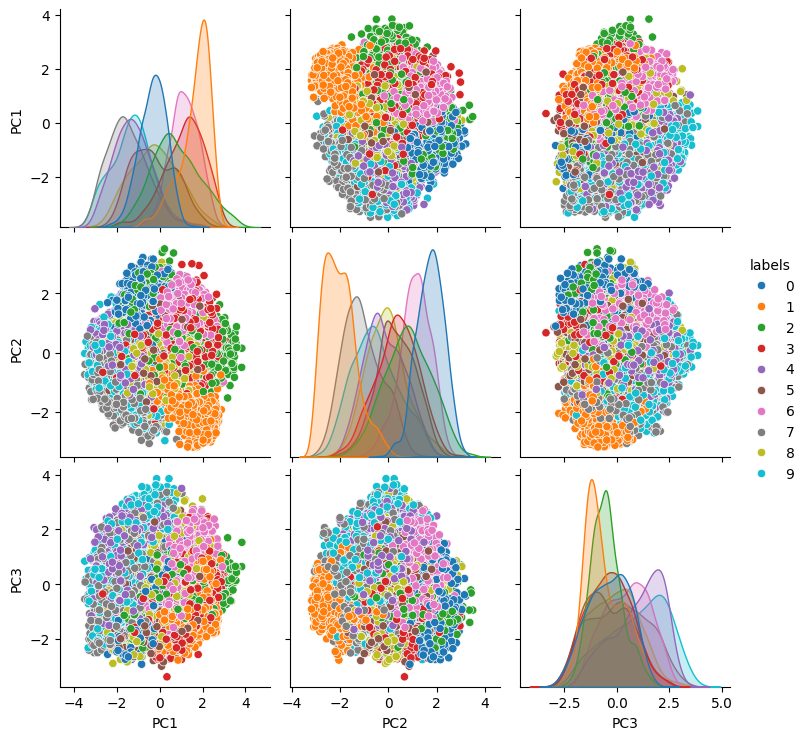

Showing pairplots of PCA for digits 2 ,7 ,

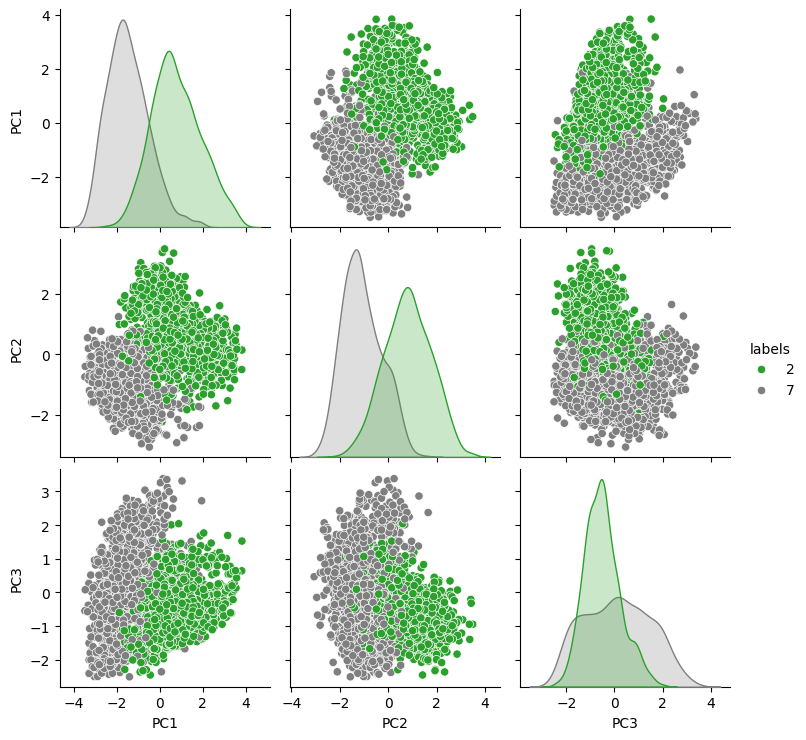

Showing pairplots of PCA for digits 0 ,1 ,

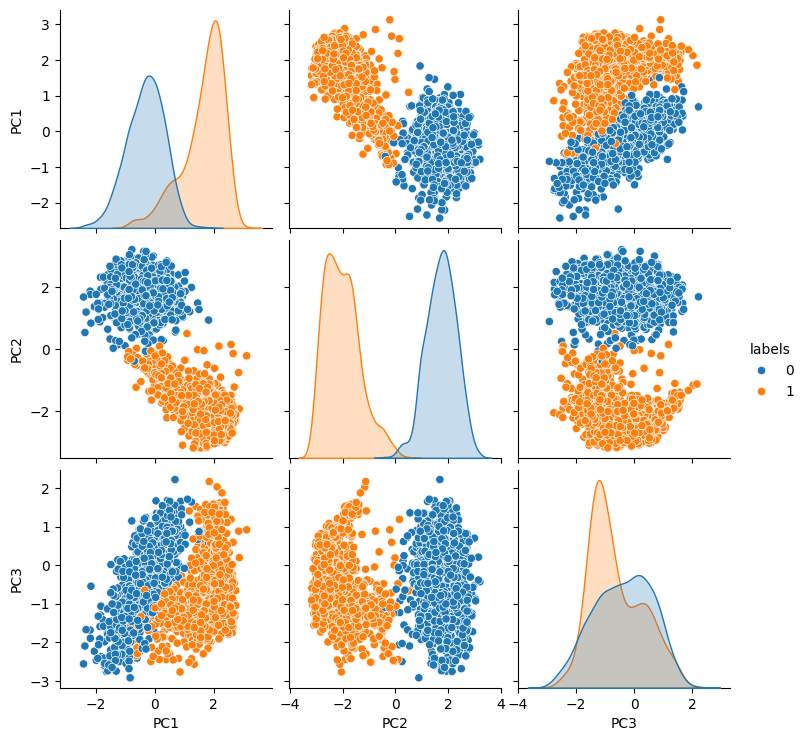

Showing pairplots of PCA for digits 3 ,5 ,

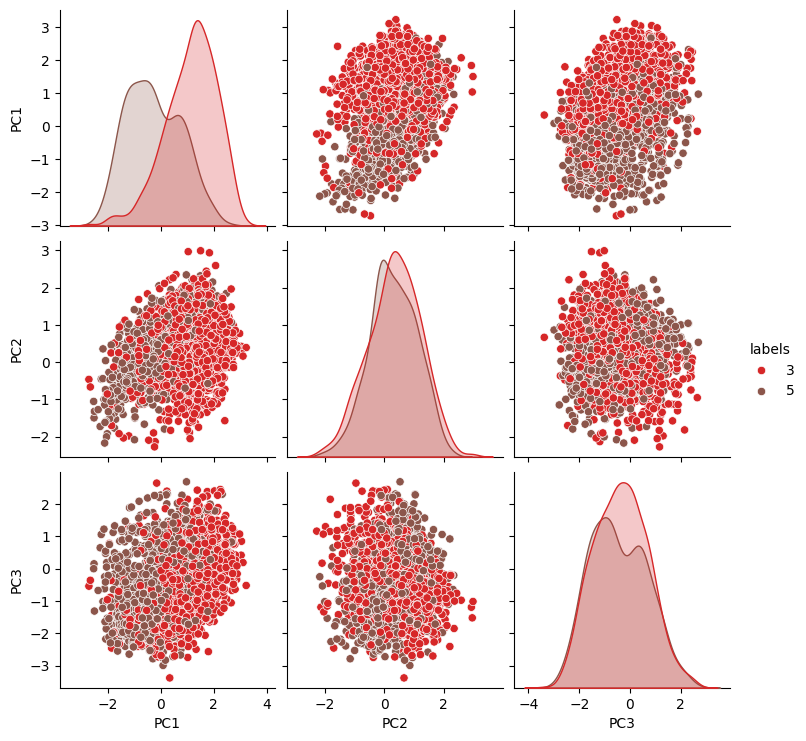

Showing pairplots of PCA for digits 4 ,6 ,

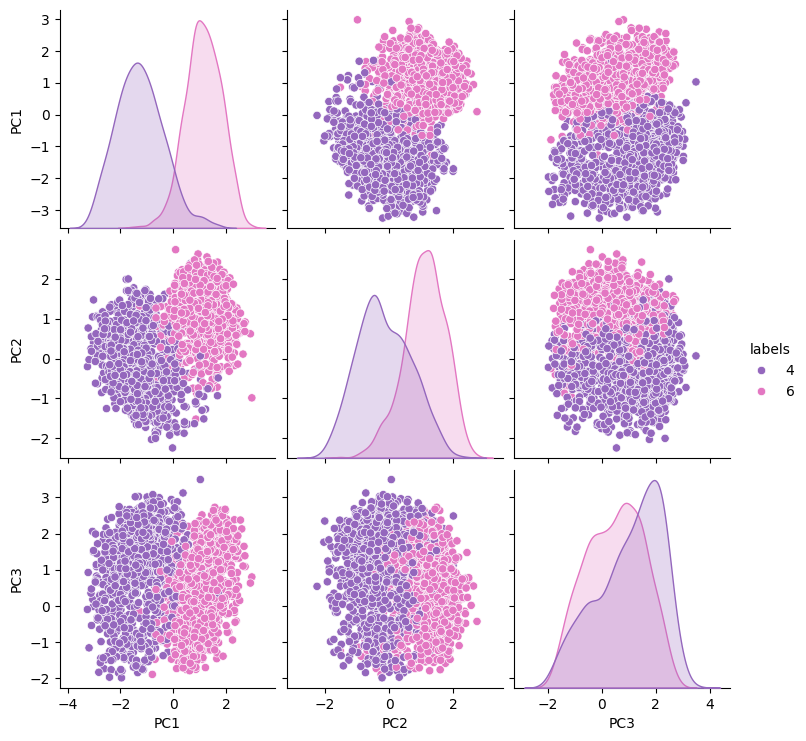

In [122]:
PCA_and_plot_latent(test_ds,vae)

Overall PCA results ,52.66 % variance is explained


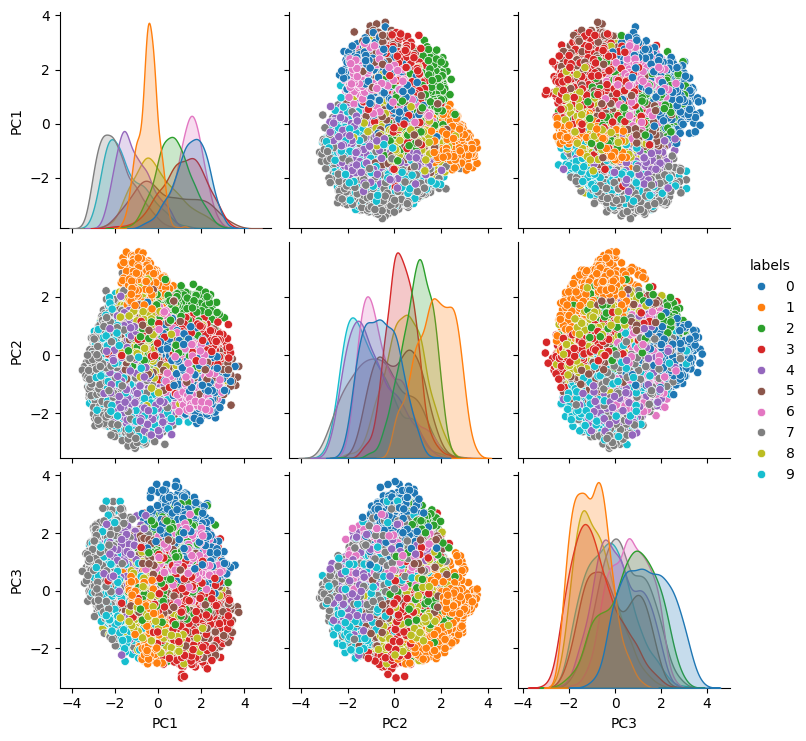

Showing pairplots of PCA for digits 2 ,7 ,

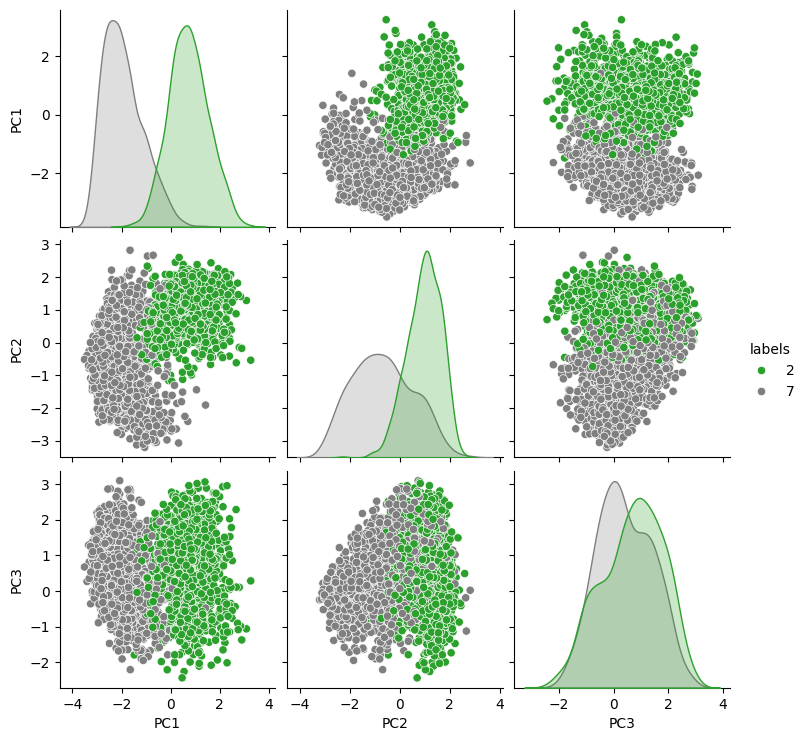

Showing pairplots of PCA for digits 0 ,1 ,

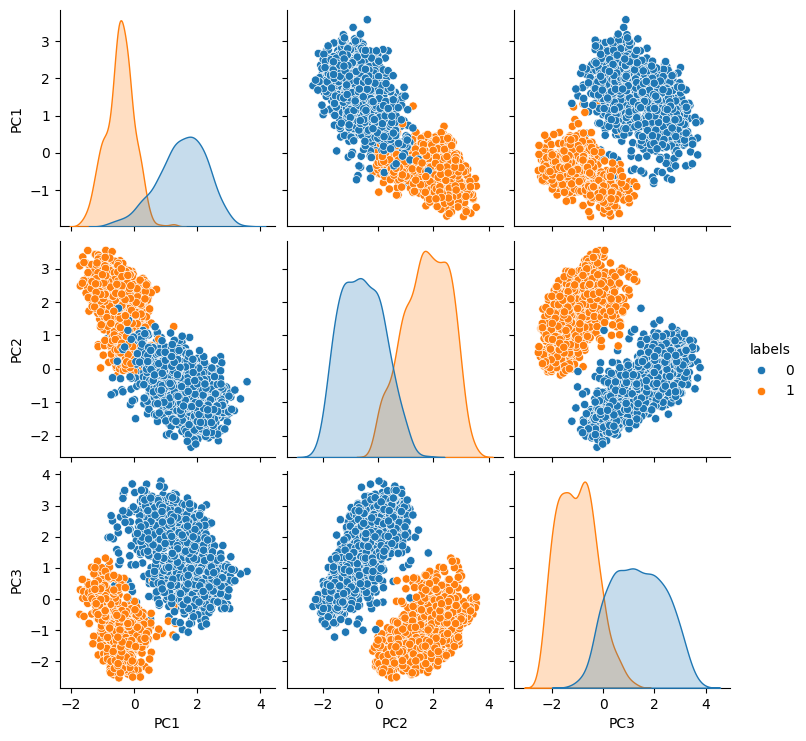

Showing pairplots of PCA for digits 3 ,5 ,

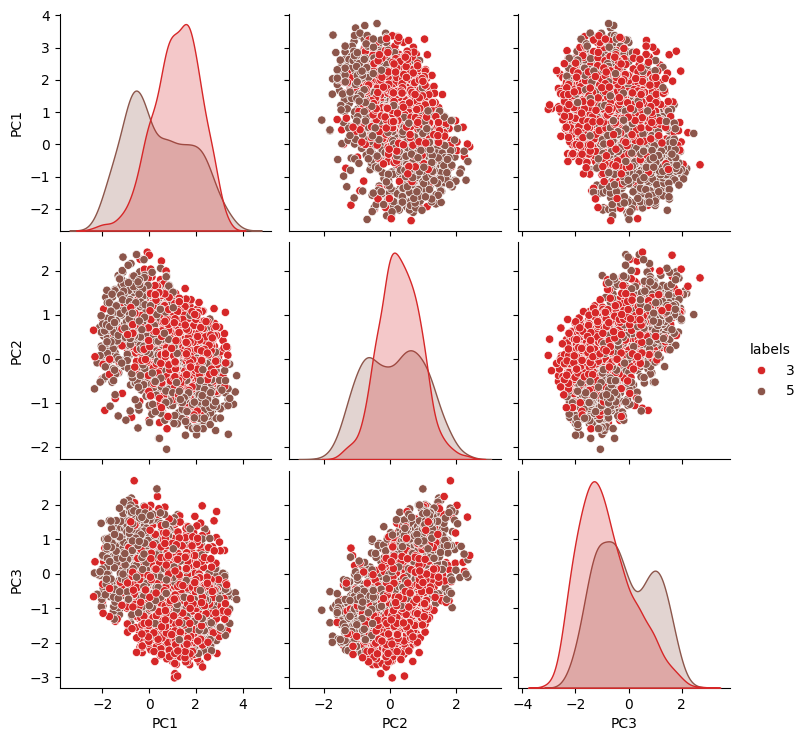

Showing pairplots of PCA for digits 4 ,6 ,

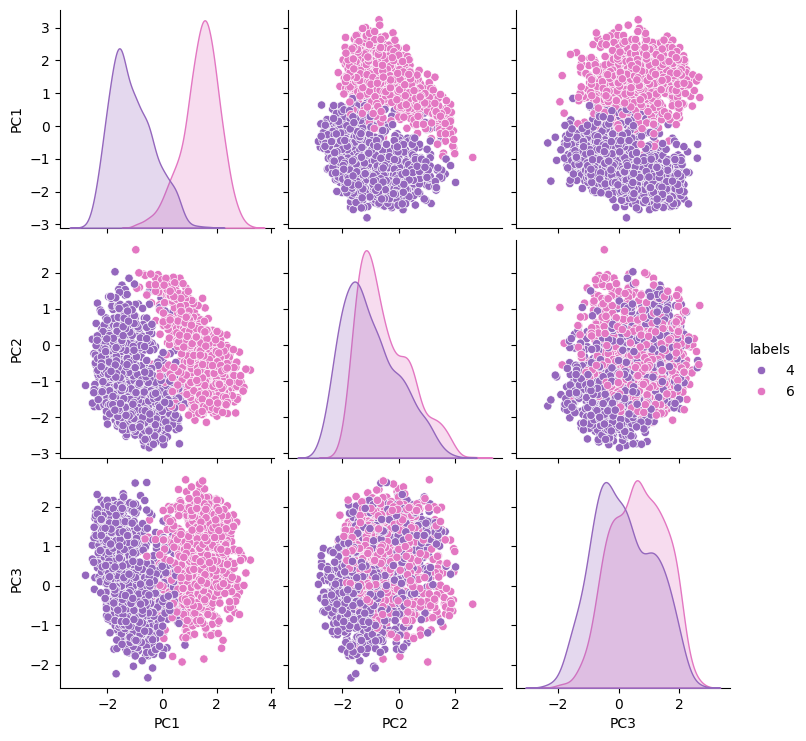

In [123]:
PCA_and_plot_latent(test_ds,ae)

In [87]:
#Creates a map for all 10 digits containing 10 samples for each
class_mp={}
cnt=0
cnt_per_dig=10
for index,(image, target) in enumerate(test_ds):
    batch_sz=len(target)
    for x in range(batch_sz):
        img=image[x]
        tar=int(target[x])
        if tar not in class_mp:
            class_mp[tar]=[]
        if len(class_mp[tar])<cnt_per_dig:
            class_mp[tar].append(img)
            cnt+=1
        if cnt==10*cnt_per_dig:
            break
    if cnt==10*cnt_per_dig:
        break

# Shows the selected samples for an digit
def show_samples(dig:int):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i in range(10):
        axes[int(i>=5), i%5].imshow(255*invTrans(class_mp[dig][i].permute(1, 2, 0)),cmap='binary')
    plt.tight_layout()
    plt.show()

In [129]:

# Given starting and ending digits and model choice ,shows movement between the 2 points/distribution samples in the latent space
def latent_space_transform(model_ae:Autoencoder,model_vae:VAE,gif:str,dig_info:tuple,class_mp: typing.Dict[int, typing.List[torch.Tensor]],inv_trans=transforms.Normalize((0.0), (1.0))):
    plt.ioff()
    start_dig,end_dig,choice_1,choice_2=dig_info
    # pick random if digit sample not specified
    if choice_1<0 or choice_2<0:
        choice_1=np.random.randint(10)
        choice_2=np.random.randint(10)

    # Initial and final vectors in latent space
    init_LS_ae=torch.from_numpy(get_latent(class_mp[start_dig][choice_1],model_ae))
    final_LS_ae=torch.from_numpy(get_latent(class_mp[end_dig][choice_2],model_ae))

    init_LS_vae=torch.from_numpy(get_latent(class_mp[start_dig][choice_1],model_vae))
    final_LS_vae=torch.from_numpy(get_latent(class_mp[end_dig][choice_2],model_vae))
    model_ae.eval()
    model_vae.eval()
    time=4 #In seconds
    fps=16 #frames per second
    tot_frames=fps*time

    # Create the figure
    fig = plt.figure()
    # The frame update function
    def update(frame):
        plt.clf()  # Clear the current figure

        alpha=frame/(tot_frames-1)
        plt.subplot(1,2,1)
        
        latent_mid = (1 - alpha)*init_LS_ae + alpha*final_LS_ae
        latent_mid=latent_mid.to(device)

        # Get back to device
        op=torch.reshape(model_ae.decoder(latent_mid),(-1,28,28)).permute(1,2,0).detach().cpu()
        plt.imshow(255*inv_trans(op),cmap='binary')
        plt.title("AE")


        plt.subplot(1,2,2)

        latent_mid = (1 - alpha)*init_LS_vae + alpha*final_LS_vae
        latent_mid=latent_mid.to(device)

        # Get back to device
        op=torch.reshape(model_vae.decoder(latent_mid),(-1,28,28)).permute(1,2,0).detach().cpu()
        plt.imshow(255*inv_trans(op),cmap='binary')
        plt.title("VAE")
    # Generate and save the animation
    fig = plt.figure()
    ani = animation.FuncAnimation(fig, update, frames=tot_frames, interval=1000/fps)
    ani.save(gif+"_"+str(start_dig)+ "_"+str(end_dig)+'.gif', writer='pillow')
    plt.close()
    plt.ion()


In [130]:
# KARTIK Give tuple as (d1,d2,-1,-1) if you dont want to pick  particular example
latent_space_transform(ae,vae,"test",(3,8,-1,-1),class_mp,invTrans)

In [131]:
latent_space_transform(ae,vae,"test",(2,7,-1,-1),class_mp,invTrans)

In [132]:
# KARTIK Shows advantage of VAE in cases when latent of highly different figures
latent_space_transform(ae,vae,"test",(0,1,-1,-1),class_mp,invTrans)


In [133]:
latent_space_transform(ae,vae,"test",(4,6,-1,-1),class_mp,invTrans)